# 对比各流域的农业用水压力

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import sys
sys.path.append("..")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.facecolor'] = 'white'

# 自定义配色
nature_colors = {
    'NS': "#c83c1c",
    'Nature': "#29303c",
    'NCC': "#0889a6",
    'NC': "#f1801f",
    'NG': "#006c43",
    'NHB': "#1951A0",
    'NEE': "#C7D530"
}

### Zhou老师用水量数据

In [2]:
# 周老师的用水数据
pns = pd.read_excel("../data/large/Zhou et al_2020_PNAS_dataset.xlsx", 1)

# 清洗数据的头部，让两行头部变一行
change_name_dic = {}
last_item = "None"
for col in pns:
    second_row = pns.loc[0, col]
    if "Unnamed" in col:
        change_name_dic[col] = last_item + ": " + second_row
    else:
        if type(second_row) is str:
            change_name_dic[col] = col + ": " + second_row
        last_item = col

pns.rename(change_name_dic, axis=1, inplace=True)
pns = pns.drop(0)

# 重命名表头，取消两边的空格
pns.rename({col: col.strip() for col in pns}, axis=1, inplace=True)

# 更改正确的数据类型
pns = pns.astype(float, errors='ignore')
pns['Year'] = pns['Year'].astype(int)
pns.iloc[:, 2:] = pns.iloc[:, 2:].astype(float)

pns.head()

,City_ID,Year,IRR,Irrigated area: Total,Irrigated area: Rice,Irrigated area: Wheat,Irrigated area: Maize,Irrigated area: Vegetables and fruits,Irrigated area: Others,Irrigation water-use intensity (WUI): Total,...,Service GVA,Service WUI,RUR,Rural domestic WU,Rural population,Rural domestic WUI,Rural livestock WU,Livestock population,Livestock WUI,Total water use
1,C1,1965,1.229927,127.315625,59.834838,8.289719,0.443002,2.697220,56.050846,966.045314,...,0.044986,0.016339,0.016483,0.014680,0.469140,85.727127,0.001804,110.158490,0.016373,1.261649
2,C1,1966,1.274452,129.968097,62.355186,7.819602,0.404165,2.741800,56.647345,980.588287,...,0.053715,0.015736,0.018686,0.016790,0.516349,89.085128,0.001896,115.778437,0.016380,1.308981
3,C1,1967,1.482867,152.163380,68.736923,9.776923,0.489071,3.267321,69.893142,974.522696,...,0.062626,0.014725,0.020151,0.018158,0.561759,88.556282,0.001993,121.665631,0.016385,1.519409
4,C1,1968,1.538731,156.787722,74.005815,10.511051,0.529418,3.443728,68.297710,981.410519,...,0.072619,0.013645,0.021343,0.019248,0.605370,87.108619,0.002095,127.834367,0.016389,1.577010
5,C1,1969,1.642901,165.174460,83.210254,10.657419,0.569342,3.536641,67.200804,994.645761,...,0.088720,0.012364,0.023139,0.020938,0.647184,88.636981,0.002201,134.298872,0.016391,1.683614


周老师的数据是用各省的水资源利用调查+各省用水量公报用水量整合起来的用水量

假设水资源利用强度长期不变的基础上，按照经济指标进行的计算和拆分

因此在这里最原始的数据就是各个地级市（甚至只有省）的总用水量。

### 武旭同流域Shp数据+周老师数据 Identify

利用师兄给的 Shpfile 文件数据，加上周老师地级市的数据，使用GIS的 Identify 方法，为每个地级市标记它属于哪个一级流域。

需要查一下 Identify 的算法。

In [3]:
identify = pd.read_excel("../data/private/perfectures_identity.xlsx", index_col=0)
identify.dropna().head()

,area,Shaoefile_,Perfecture,Province_n,MBASIN_ID,MNAME,CATCHMNT,MNAME_CH,LABEL_CH,Shape_Length,Shape_Area
OBJECTID,,,,,,,,,,,
96,82968.008535,1,C270,Sichuan,10,Yellow River,Pacific,黄河流域,黄河,11.305782,1.642756
97,82968.008535,1,C270,Sichuan,13,Yangtze River,Pacific,长江流域,长江,24.818387,6.310526
98,131711.312178,2,C299,Xinjiang,31,Ili River,Interior,伊梨河内流区,伊梨河,4.422079,0.077114
99,131711.312178,2,C299,Xinjiang,32,Tarim,Interior,塔里木内流区,塔里木,19.143951,14.000780
100,239466.096421,4,C206,Neimeng,10,Yellow River,Pacific,黄河流域,黄河,8.427197,0.266050


In [4]:
print("看看不同的流域，分别包含了多少个地级市，到时候好对比")
identify.groupby("MNAME_CH").count().iloc[:, 0].sort_values(ascending=False).head(10)

看看不同的流域，分别包含了多少个地级市，到时候好对比


MNAME_CH
长江流域          134
黄河流域           77
珠江流域           47
淮河流域           42
海河流域           38
东南沿海诸河流域       35
黑龙江流域          29
辽河流域           21
河西走廊阿拉善内流区     20
塔里木内流区         14
Name: area, dtype: int64

将周 PNAS 的数据和分属于哪个一级流域的数据整合到一起：

In [5]:
merged_data = pd.merge(
    left=pns,
    right=identify,
    left_on='City_ID',
    right_on='Perfecture',
    right_index=False,
    left_index=False,
)

merged_data.head()
merged_data[merged_data['Year'] == 2000].groupby("MNAME_CH").count().iloc[:, 0].sort_values(ascending=False).head(10)

,City_ID,Year,IRR,Irrigated area: Total,Irrigated area: Rice,Irrigated area: Wheat,Irrigated area: Maize,Irrigated area: Vegetables and fruits,Irrigated area: Others,Irrigation water-use intensity (WUI): Total,...,Shaoefile_,Perfecture,Province_n,MBASIN_ID,MNAME,CATCHMNT,MNAME_CH,LABEL_CH,Shape_Length,Shape_Area
0,C1,1965,1.229927,127.315625,59.834838,8.289719,0.443002,2.697220,56.050846,966.045314,...,8,C1,Anhui,12,Huai River,Pacific,淮河流域,淮河,1.149281,0.047989
1,C1,1965,1.229927,127.315625,59.834838,8.289719,0.443002,2.697220,56.050846,966.045314,...,8,C1,Anhui,13,Yangtze River,Pacific,长江流域,长江,7.508193,1.398109
2,C1,1966,1.274452,129.968097,62.355186,7.819602,0.404165,2.741800,56.647345,980.588287,...,8,C1,Anhui,12,Huai River,Pacific,淮河流域,淮河,1.149281,0.047989
3,C1,1966,1.274452,129.968097,62.355186,7.819602,0.404165,2.741800,56.647345,980.588287,...,8,C1,Anhui,13,Yangtze River,Pacific,长江流域,长江,7.508193,1.398109
4,C1,1967,1.482867,152.163380,68.736923,9.776923,0.489071,3.267321,69.893142,974.522696,...,8,C1,Anhui,12,Huai River,Pacific,淮河流域,淮河,1.149281,0.047989


MNAME_CH
长江流域          134
黄河流域           77
珠江流域           47
淮河流域           42
海河流域           38
东南沿海诸河流域       35
黑龙江流域          29
辽河流域           21
河西走廊阿拉善内流区     20
塔里木内流区         14
Name: City_ID, dtype: int64

可以看到，整合后的数据和每个流域对应的数量还是一样的，说明数据结合的没有问题

In [6]:
# 根据流域和年份来整合用水量
pivot_data = merged_data.pivot_table(
    index=['MNAME_CH', 'Year'],
    values=['Total water use', 'IRR', 'IND', 'RUR', 'URB'],
    aggfunc='sum',
)

pivot_data

IND        IRR       RUR  Total water use       URB
MNAME_CH Year                                                           
东南沿海诸河流域 1965   1.968130  33.537098  1.884541        38.103509  0.713741
         1966   2.164821  29.095042  2.063005        34.107495  0.784626
         1967   2.224415  26.662563  2.046025        31.744881  0.811879
         1968   2.130556  26.775538  1.991602        31.726288  0.828592
         1969   2.458723  27.559358  2.054643        32.956157  0.883432
...                  ...        ...       ...              ...       ...
黑龙江流域    2009  12.763595  29.190351  1.888304        47.215969  3.373719
         2010  14.341168  31.202411  1.997986        51.538605  3.997039
         2011  14.993033  29.744545  1.972510        50.594003  3.883915
         2012  14.535686  30.526126  2.005637        50.940244  3.872796
         2013  14.525249  35.527621  2.045629        55.982271  3.883772

[1911 rows x 5 columns]

In [7]:
merged_data.to_csv("../data/large/pnas_identified.csv")

### 读图用水数据

In [8]:
import os, sys

# 我们这里关心的是由统一的大河链接起来的一级流域，每个一级流域用最后一个最接近入海口的水文站来代表其入海前的实测径流量。
BASINS = {
    '淮河流域': '蚌埠吴家渡',
    '珠江流域': '高要',
    '长江流域': '大通',
    '海河流域': '海河闸',
    '黄河流域': '利津',
    '辽河流域': '六间房'
}

path = "../data/private/九大流域用水变化_读图/"

runoff = pd.DataFrame(index=np.arange(1950, 2020))
for basin in os.listdir(path):
    if basin in BASINS:
        file = os.path.join(path, basin, f"{basin}.xlsx")
        runoff[basin] = pd.read_excel(file, BASINS[basin], index_col='年份')['年平均径流量']
runoff = runoff.dropna(axis=0, how='all')
runoff

,淮河流域,珠江流域,长江流域,海河流域,黄河流域,辽河流域
1950,463.492063,NaN,9863.945578,NaN,NaN,NaN
1951,171.428571,NaN,8367.346939,NaN,NaN,NaN
1952,339.682540,NaN,10680.272109,NaN,457.297297,NaN
1953,180.952381,NaN,8911.564626,NaN,437.837838,NaN
1954,634.920635,NaN,13605.442177,NaN,578.918919,NaN
...,...,...,...,...,...,...
2010,321.400000,1925.0,10220.000000,2.852,193.000000,70.97
2011,92.940000,1341.0,6671.000000,4.646,184.200000,23.27
2012,110.700000,2111.0,10020.000000,8.699,282.500000,28.98
2013,83.720000,2009.0,7878.000000,3.907,236.900000,57.20


In [9]:
total_wu = pd.DataFrame()
for basin in BASINS:
    total_wu[basin] = pivot_data.loc[basin, 'IRR'] * 10
    
total_wu.head()
total_wu.shape

,淮河流域,珠江流域,长江流域,海河流域,黄河流域,辽河流域
Year,,,,,,
1965,362.929319,350.016486,949.468606,205.691335,275.356508,77.725310
1966,393.021246,337.737825,944.023591,252.866864,301.162694,81.706140
1967,413.081605,344.336983,940.288007,256.809482,315.114621,84.291276
1968,419.332214,351.366527,952.283915,272.727283,328.039803,77.328628
1969,429.180684,358.228257,963.207999,284.759006,343.134355,105.058690


(49, 6)

In [10]:
# 还原后的天然河川径流量
reducted = (runoff + total_wu).dropna(how='all')

ratio = pd.DataFrame()
# 计算用水量占天然河川径流量的比例
for basin in BASINS:
    ratio[basin] = total_wu[basin] / reducted[basin]
    
ratio.head()

,淮河流域,珠江流域,长江流域,海河流域,黄河流域,辽河流域
Year,,,,,,
1965,0.562272,0.135254,0.097632,0.879482,0.420510,NaN
1966,0.911636,0.136279,0.108519,0.901040,0.424286,NaN
1967,0.751618,0.143247,0.095443,0.885641,0.314781,NaN
1968,0.579113,0.099544,0.091495,0.979165,0.369623,NaN
1969,0.531850,0.141525,0.098905,0.906330,0.544518,NaN


可以看到，还需要使用地下水所占用水量的比例对用水量进行修正

## 使用地下水占比进行修正

使用水资源公报中近20年来地下水和地表水的使用占比，为每个一级流域过去用水的大致来源进行估计修正。

$$\alpha = \frac{WU_{surface}}{WU_{total}} $$

$$ pnas_{surface} = pnas_{total} * \alpha $$

其中 $WU$ 是来自水资源公报的用水数据，而 $pnas$ 是来自周老师数据的用水量。

In [11]:
# 利用

water_source = pd.read_excel("../data/water_source.xlsx", index_col=0, header=1)
water_source_columns = pd.read_excel("../data/water_source.xlsx", index_col=0).columns.tolist()

alpha_dic = {}
for i in BASINS:
    abstract_name = i[:2]
    if abstract_name in water_source_columns:
        index = water_source_columns.index(abstract_name)
        surface, ground, others = water_source.iloc[:, index:index+3].mean().values
        alpha = surface / (surface + ground + others)
        alpha_dic[i] = alpha
    else:
        print(f"No matched name: {i}")
        
alpha_dic

{'淮河流域': 0.7438790663623189,
 '珠江流域': 0.9644386884230434,
 '长江流域': 0.9610771972765328,
 '海河流域': 0.2816157657114495,
 '黄河流域': 0.7423402473215703,
 '辽河流域': 0.4482359377935958}

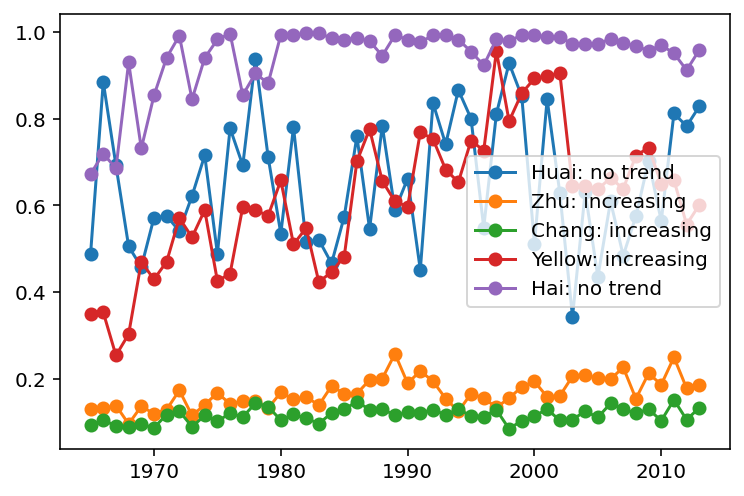

In [15]:
# 还原后的天然河川径流量
ENG_NAME = {
    '淮河流域': 'Huai', 
    '珠江流域': 'Zhu', 
    '长江流域': 'Chang', 
    '黄河流域': 'Yellow', 
    '海河流域': 'Hai', 
}

from tools.mk_test import mk_test
fig, ax = plt.subplots()

ratio = pd.DataFrame()
# 计算用水量占天然河川径流量的比例
for basin in ENG_NAME:
    wu = total_wu[basin] * alpha_dic[basin]
    reducted = (runoff[basin] + wu).dropna(how='all')
    tmp_ratio = wu / reducted
    ratio[basin] = tmp_ratio
    trend = mk_test(tmp_ratio.values)[0]
    ax.plot(total_wu.index, tmp_ratio, "-o", label="{}: {}".format(ENG_NAME[basin], trend))
    
ax.legend()
plt.show();

四种不同的类型：

- 压力增加，压力水平大的流域：黄河
- 压力增加，但远没有达到地表水资源压力的流域：长江、珠江
- 压力不变，压力水平大：淮河
- 压力不变，压力水平极限：海河